# IMPROVE IMDB model
With 25k example, model achieved ~99% accuracy on train set, and ~88% accuracy on val set.

This note book try to improve accuracy on val set by
* Use MLP with TF IDF, which try to keep information as much as possible
* LSTM, with only top 10 word excluded ( instead of stopwords.words("english") ) 
* TF IDF + LSTM


In [109]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from keras.layers import Embedding, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM
from keras.models import Model, Sequential

In [159]:
imdb = keras.datasets.imdb
(input_train_data, input_train_labels), (input_test_data, input_test_labels) = imdb.load_data()
print("train set size is ", input_train_data.shape)

train set size is  (25000,)


In [160]:
def decode_review(text, dictionary):
    return ' '.join([dictionary.get(i, "0") for i in text])

def decode_all(input_data, dictionary):
    decode_list = []
    for i in range(len(input_data)):
        decode_ = decode_review(input_data[i], dictionary)
        decode_list.append(decode_.lower())
    return decode_list

def reverse_dictionary(word_index):
    """ Dictionary is reversed, and do not include first 4 word index"""
    word_index = {k: (v+3) for k, v in word_index.items()}
    word_index["<pad>"] = 0
    word_index["<start>"] = 1
    word_index["<unk>"] = 2 #unknow
    word_index["<unused>"] = 3
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    return reverse_word_index

word_index = imdb.get_word_index()
reverse_word_index = reverse_dictionary(word_index)
vocaburary_size = len(reverse_word_index)

print("vocaburary size is ", vocaburary_size)
print(decode_review(input_train_data[10], reverse_word_index))

vocaburary size is  88588
<start> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and switchblade romance bursting on to the scene maléfique preceded the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made maléfique was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is complimented by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named carrère sent to prison for fraud he is put in a cell with three others the quietly insane lassalle body building transvestite marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old journal after translating part of it the

### SHOW TRAIN DATA LENGTH HISTOGRAM

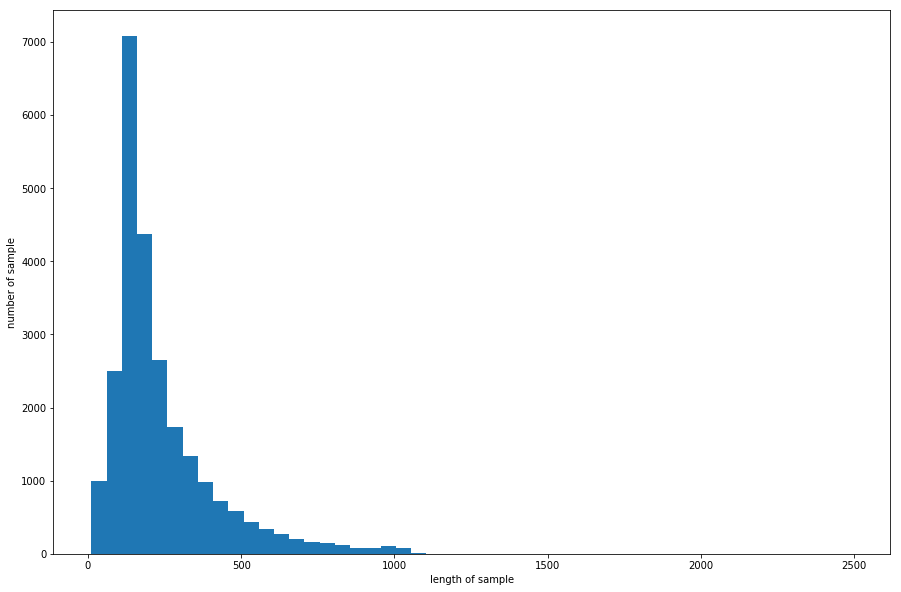

In [122]:
plt.figure(figsize=(15,10))
plt.hist([len(sample) for sample in input_train_data], 50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

### SHOW TOP 50 WORDS

In [111]:
def get_top_frequently_words(countWord, input_data, dictionary):
    input_data_train_decode = decode_all(input_data, dictionary)
    vectorizer = CountVectorizer()
    input_train_data_vector = vectorizer.fit_transform(input_data_train_decode)
    all_words = vectorizer.get_feature_names()
    all_counts = input_train_data_vector.sum(axis=0).tolist()[0]
    all_words, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_words), reverse=True)])
    ngrams = all_words[:countWord]
    counts = all_counts[:countWord]
    return ngrams, counts

('the', 'and', 'of', 'to', 'is', 'br', 'it', 'in', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'you', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', 'start', 'all', 'at', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'her', 'or', 'just', 'about', 'out', 'if', 'has', 'what', 'some', 'good', 'can', 'more', 'she')
(336758, 164141, 145865, 135724, 107336, 101871, 96471, 93978, 76007, 73287, 48209, 46936, 44345, 44130, 44047, 42623, 40161, 34268, 34203, 30634, 30155, 29438, 29376, 27732, 26957, 26795, 26700, 23985, 23516, 22916, 22549, 21564, 21441, 20616, 20499, 20281, 18866, 18424, 18007, 17774, 17375, 17113, 16809, 16791, 16169, 15749, 15147, 14678, 14253, 14228)


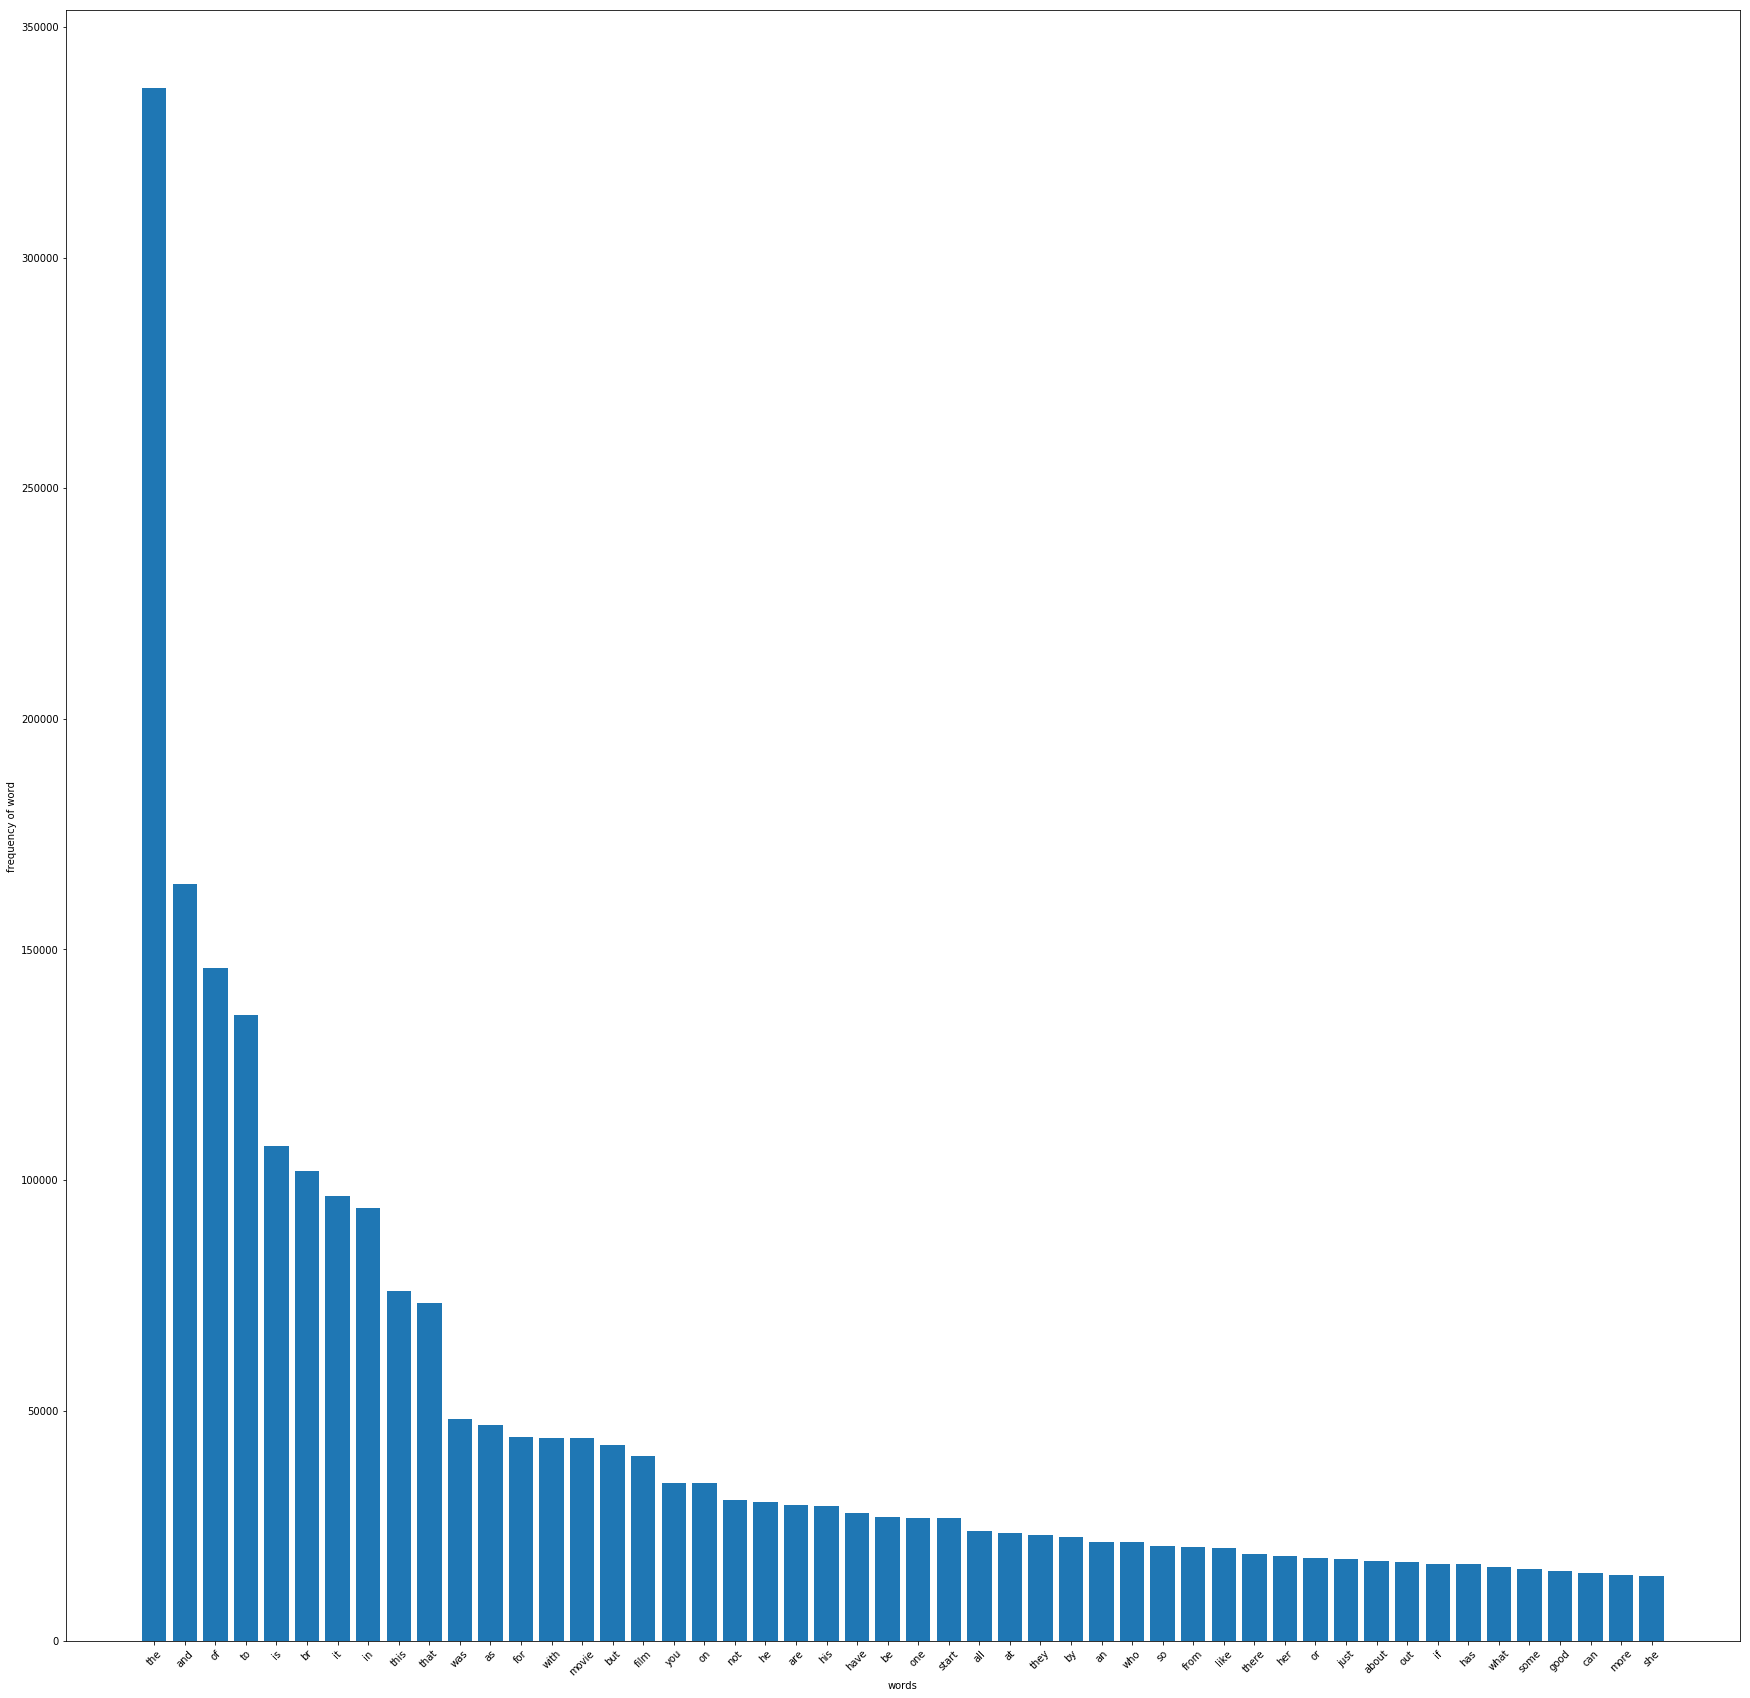

In [148]:
ngrams, counts = get_top_frequently_words(50, input_train_data, reverse_word_index)
idx = np.arange(50)
print(ngrams)
print(counts)
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, 0.8)
plt.xlabel('words')
plt.ylabel('frequency of word')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [112]:
def plot_history_loss(fit, axL):
    # Plot the loss in the history
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')

# acc
def plot_history_acc(fit, axR):
    # Plot the loss in the history
    axR.plot(fit.history['acc'],label="loss for training")
    axR.plot(fit.history['val_acc'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')
    
def ngram_vectorize(texts, labels):
    tfidf_vetorizer = TfidfVectorizer()
    x_train = tfidf_vetorizer.fit_transform(texts)
    # Select best k features, with feature importance measured by f_classif
#     selector = SelectKBest(f_classif, k=min(30000, x_train.shape[1]))
#     selector.fit(x_train, labels)
#     x_train = selector.transform(x_train).astype('float32')
    return x_train

In [148]:
def load_data():
    """ Return : 
     - train_data_text
     - train_data_label 
     - test_data_text
     - test_data_label
     """
    imdb = keras.datasets.imdb
    (input_train_data, input_train_labels), (input_test_data, input_test_labels) = imdb.load_data()
    word_index = imdb.get_word_index()
    reverse_word_index =  reverse_dictionary(word_index)
    
    input_data_train_decode = decode_all(input_train_data, reverse_word_index)
    input_data_test_decode = decode_all(input_test_data, reverse_word_index)
    
    return (input_data_train_decode, input_train_labels, 
           input_data_test_decode, input_test_labels)
    
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    model = Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    for _ in range(layers - 1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [143]:
def train_ngram_model(learning_rate=1e-3, epochs=1000, batch_size=128, layers=2, units=64, dropout_rate=0.2):
    num_classes=2
    input_train_data, input_train_labels, input_test_data, input_test_labels = load_data()
#     word_index = imdb.get_word_index()
#     reverse_word_index =  reverse_dictionary(word_index)
    
#     input_data_train_decode = decode_all(input_train_data, reverse_word_index)
    input_train_data_vector=ngram_vectorize(input_train_data, input_train_labels)
    
    model = mlp_model(
        layers=layers, units=units, dropout_rate=dropout_rate, 
        input_shape=input_train_data_vector.shape[1:], num_classes=num_classes)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    fit = model.fit(input_train_data_vector, input_train_labels, epochs=20, batch_size=128, callbacks=callbacks, validation_split=0.15)
    
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    plot_history_loss(fit, axL)
    plot_history_acc(fit, axR)
#     model.save('imdb_mlp_model.h5')
    return
    

In [144]:
import re
def clean_text(text, stop_words):
    text=text.lower()
    text = re.split(' ', text)
#     text = [w.translate(table) for w in text]
    text = [w for w in text if not w in stop_words]
    text = ' '.join(text)
    return text

def clean_text_list(text_list, stop_words):
    ret = []
    for text in text_list:
        ret.append(clean_text(text, stop_words))
    return ret

def remove_top_words(train_texts, test_texts):
    word_index = imdb.get_word_index()
    reverse_word_index =  reverse_dictionary(word_index)
    ngrams, counts = get_top_frequently_words(30, input_train_data, reverse_word_index)

    keep_words = ['movie', 'film']
    stop_words = ['<start>', '<pad>', '<unk>', '<unused>']
    ngrams, counts = get_top_frequently_words(10, input_train_data, reverse_word_index)
    stop_words.extend(w for w in list(ngrams) if not w in keep_words)
    
    cleaned_train_text = clean_text_list(train_texts, stop_words)
    cleaned_test_text = clean_text_list(test_texts, stop_words)
    
    return (cleaned_train_text, cleaned_test_text)
    for text in train_texts:
        cleaned_train_text.appned(clean_text, )

In [145]:
def word_vectorizer(train, test):
    vectorizer = CountVectorizer()
    all_data = np.concatenate([train, test])
    vectorizer.fit(all_data)
    all_ngrams = vectorizer.get_feature_names()
    return vectorizer

def text_to_sequences(train, test):
    all_text = np.concatenate([train, test])
    tokenizer = keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(all_text)
    train_to_sequence = tokenizer.texts_to_sequences(train)
    test_to_sequence = tokenizer.texts_to_sequences(test)
    
    train_to_sequence = keras.preprocessing.sequence.pad_sequences(train_to_sequence, 
                                                       value = 0,
                                                       padding='post',
                                                       maxlen=256)
    test_to_sequence = keras.preprocessing.sequence.pad_sequences(test_to_sequence, 
                                                       value = 0,
                                                       padding='post',
                                                       maxlen=256)
    num_of_feature =  max(np.amax(train_to_sequence), np.amax(test_to_sequence)) + 1
    print('number of feature = ', num_of_feature)
    return train_to_sequence, test_to_sequence, num_of_feature

In [151]:
def lstm_model(max_features, embedding_output_dims,  units, dropout_rate, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embedding_output_dims))
    model.add(Bidirectional(LSTM(units=units, return_sequences = True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(units, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

def train_lstm(learning_rate=1e-3, embedding_output_dims =128,epochs=1000, batch_size=128, units=64, dropout_rate=0.2):
    num_classes=2
    
    train_x, train_y, test_x, test_y = load_data()
    cleaned_train_x, cleaned_test_x = remove_top_words(train_x, test_x)
    train_to_sequence, test_to_sequence, max_features = text_to_sequences(cleaned_train_x, cleaned_test_x)

    model = lstm_model(max_features=max_features, 
                       embedding_output_dims=embedding_output_dims, units=32, dropout_rate=dropout_rate, num_classes=num_classes)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    fit = model.fit(train_to_sequence, train_y, epochs=20, batch_size=128, callbacks=callbacks, validation_split=0.15)
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    plot_history_loss(fit, axL)
    plot_history_acc(fit, axR)
    return

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_10 (Dropout)         (None, 74703)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4781056   
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 4,781,121
Trainable params: 4,781,121
Non-trainable params: 0
_________________________________________________________________
Train on 21250 samples, validate on 3750 samples
Epoch 1/20
21250/21250 [==============================] - 45s 2ms/step - loss: 0.5165 - acc: 0.8249 - val_loss: 0.3532 - val_acc: 0.8829
Epoch 2/20
21250/21250 [==============================] - 45s 2ms/step - loss:

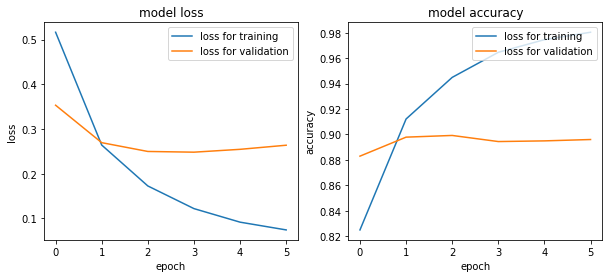

In [149]:
%%time
train_ngram_model()

number of feature =  88572
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         11337216  
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 11,380,545
Trainable params: 11,380,545
Non-trainable params: 0
_____________________________________

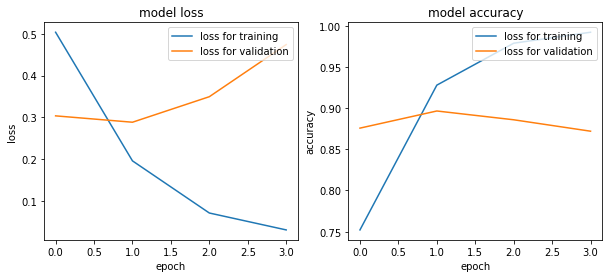

In [161]:
%%time
train_lstm()